In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

In [3]:
from zipfile import ZipFile
file_name = "Flickr8k_Dataset.zip" #Do give a proper directory
with ZipFile(file_name, 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

from zipfile import ZipFile
file_name = "Flickr8k_text.zip" #Do give a proper directory
with ZipFile(file_name, 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

Extracting all the files now...
Done!
Extracting all the files now...
Done!


In [52]:
from pickle import load,dump
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical,plot_model
import numpy as np
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input

# Model

In [39]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_set(filename):
    doc = load_doc(filename)
    dataset = []
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

def load_clean_descriptions(filename, dataset):
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        if image_id in dataset:
            if image_id not in descriptions:
                descriptions[image_id] = []
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions

def load_photo_features(filename, dataset):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in dataset}
    return features

filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: ',len(train))
train_descriptions = load_clean_descriptions('/content/descriptions.txt', train)
print('Descriptions: train=',len(train_descriptions))
train_features = load_photo_features('/content/features.pkl', train)
print('Photos: train=',len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


In [40]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ',vocab_size)

Vocabulary Size: 3848


In [41]:
def create_sequences(tokenizer, max_length, descriptions, photos):
    X1, X2, y = list(), list(), list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [ ]:
"""
Here is a example of how our train and test sets would look like after sequences are created
X1,     X2 (text sequence),                         y (word)
photo   startseq,                                   little
photo   startseq, little,                           girl
photo   startseq, little, girl,                     running
photo   startseq, little, girl, running,            in
photo   startseq, little, girl, running, in,        field
photo   startseq, little, girl, running, in, field, endseq
"""

In [42]:
def define_model(vocab_size, max_length):
    inputs1 = tf.keras.layers.Input(shape=(1000,))
    fe1 = tf.keras.layers.Dropout(0.5)(inputs1)
    fe2 = tf.keras.layers.Dense(256, activation='relu')(fe1)
    inputs2 = tf.keras.layers.Input(shape=(max_length,))
    se1 = tf.keras.layers.Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = tf.keras.layers.Dropout(0.5)(se1)
    se3 = tf.keras.layers.LSTM(256)(se2)
    decoder1 = tf.keras.layers.add([fe2, se3])
    decoder2 = tf.keras.layers.Dense(256, activation='relu')(decoder1)
    outputs = tf.keras.layers.Dense(vocab_size, activation='softmax')(decoder2)
    model = tf.keras.models.Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [43]:
filename = '/content/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: ',len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=',len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=',len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ',vocab_size)
max_length = max_length(train_descriptions)
print('Description Length: ',max_length)
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions,train_features)
filename = '/content/Flickr_8k.devImages.txt'
test = load_set(filename)
print('Dataset: ',len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=',len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=',len(test_features))
X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions,test_features)
model = define_model(vocab_size, max_length)

Dataset: 6000
Descriptions: train=6000
Photos: train=6000
Vocabulary Size: 3848
Description Length: 30
Dataset: 1000
Descriptions: test=1000
Photos: test=1000
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 30, 256)      985088      ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=1,save_best_only=True, mode='min')
model.fit([X1train, X2train], ytrain, epochs=20, verbose=2, callbacks=[checkpoint],validation_data=([X1test, X2test], ytest))

Epoch 1/20

Epoch 00001: val_loss improved from inf to 4.41025, saving model to model.h5
1916/1916 - 225s - loss: 5.0881 - val_loss: 4.4102 - 225s/epoch - 117ms/step
Epoch 2/20


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)



Epoch 00002: val_loss improved from 4.41025 to 4.13831, saving model to model.h5
1916/1916 - 215s - loss: 4.2758 - val_loss: 4.1383 - 215s/epoch - 112ms/step
Epoch 3/20

Epoch 00003: val_loss improved from 4.13831 to 4.04852, saving model to model.h5
1916/1916 - 215s - loss: 3.9233 - val_loss: 4.0485 - 215s/epoch - 112ms/step
Epoch 4/20

Epoch 00004: val_loss improved from 4.04852 to 4.01907, saving model to model.h5
1916/1916 - 225s - loss: 3.6790 - val_loss: 4.0191 - 225s/epoch - 118ms/step
Epoch 5/20

Epoch 00005: val_loss did not improve from 4.01907
1916/1916 - 240s - loss: 3.4749 - val_loss: 4.0342 - 240s/epoch - 125ms/step
Epoch 6/20

Epoch 00006: val_loss did not improve from 4.01907
1916/1916 - 216s - loss: 3.2971 - val_loss: 4.1140 - 216s/epoch - 113ms/step
Epoch 7/20

Epoch 00007: val_loss did not improve from 4.01907
1916/1916 - 219s - loss: 3.1351 - val_loss: 4.1891 - 219s/epoch - 114ms/step
Epoch 8/20

Epoch 00008: val_loss did not improve from 4.01907
1916/1916 - 220s -

KeyboardInterrupt: ignored

In [48]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

In [49]:
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()

    for key, desc_list in descriptions.items():
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        yhat = cleanup_summary(yhat)
        references = [cleanup_summary(d).split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [50]:
filename = '/content/model.h5'
model_trial = load_model(filename)
evaluate_model(model_trial, test_descriptions, test_features, tokenizer, max_length)

BLEU-1: 0.198366
BLEU-2: 0.096380
BLEU-3: 0.065166
BLEU-4: 0.025863


In [53]:
dump(tokenizer, open('tokenizer.pkl', 'wb'))

# Evaluation

In [61]:
import cv2
from google.colab.patches import cv2_imshow

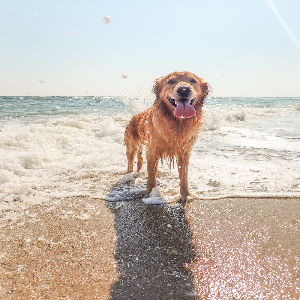

brown dog is running through the grass


In [63]:
def extract_features(filename):
    model = VGG16()
    model.layers.pop()
    model = tf.keras.models.Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
      if index == integer:
        return word
    return None

def cleanup_summary(summary):
    index = summary.find('startseq ')
    if index > -1:
        summary = summary[len('startseq '):]
    index = summary.find(' endseq')
    if index > -1:
        summary = summary[:index]
    return summary

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('/content/tokenizer.pkl', 'rb'))
max_length = 30
model = load_model('/content/model.h5')
photo = extract_features('/content/photo.jfif')
description = generate_desc(model, tokenizer, photo, max_length)
description = cleanup_summary(description)
img = cv2.imread('/content/photo.jfif')
img = cv2.resize(img,(300,300))
cv2_imshow(img)
print(description)

Need to train the model a lot more to make predictions better